Afisare date initiale

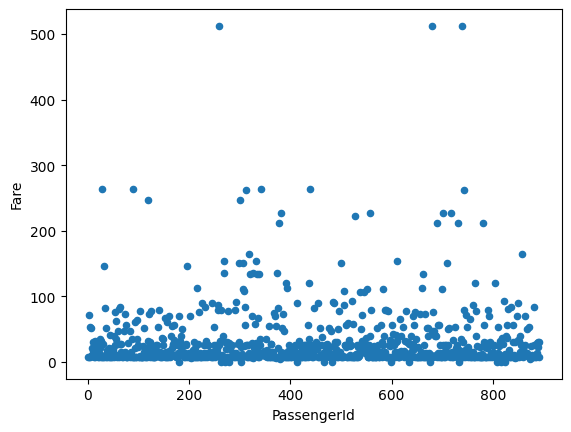

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('train.csv')

#pregatirea setului de date
for col in ['Age', 'Fare', 'SibSp', 'Parch']:
  mean = np.mean(df[col])
  df[col].fillna(mean, inplace = True)

df.plot(kind = 'scatter', x = 'PassengerId', y = 'Fare')
plt.show()

**Cerinta 1:** Folositi interquartile range pentru a identifica si elimina outlier-ele. O valoare
este considerată outlier dacă este mai mică decât Q1 - 1.5IQR sau mai mare decât Q3 + 1.5IQR,
unde Q1 si Q3 sunt primul si al treilea percentile, iar IQR este diferent, a dintre Q3 si Q1. Dacă
luăm de exemplu variabila "age" din setul de date Titanic, putem calcula Q1 si Q3, apoi IQR.
Valorile care sunt în afara intervalului Q1 - 1.5IQR si Q3 + 1.5IQR pot fi considerate outlier-e
si eliminate.

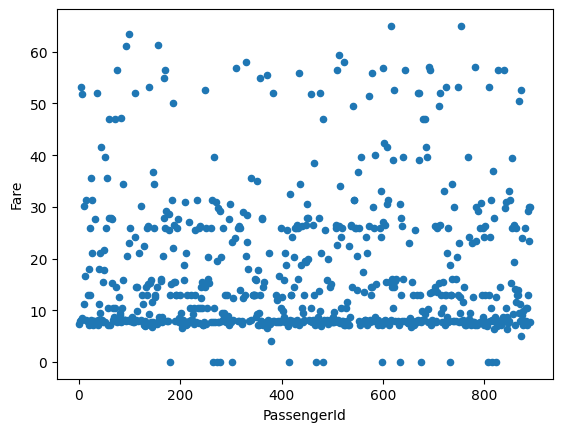

In [55]:
############################################
            # Outlieri varsta #
############################################

# calculeaza primul percentile
ageQ1 = np.percentile(df['Age'], 25)
# calculeaza al treilea percentile
ageQ3 = np.percentile(df['Age'], 75)
# interquartile range
ageIQR = ageQ3 - ageQ1

# valoarea sub care se afla outlieri
ageMinValue = ageQ1 - 1.5*ageIQR
# valoarea peste care se afla outlieri
ageMaxValue = ageQ3 + 1.5*ageIQR

# eliminare outlieri
df_age_iqr = df[(df['Age'] >= ageMinValue) & (df['Age'] <= ageMaxValue)]

############################################
            # Outlieri pret #
############################################

# calculeaza primul percentile
fareQ1 = np.percentile(df['Fare'], 25)
# calculeaza al treilea percentile
fareQ3 = np.percentile(df['Fare'], 75)
# interquartile range
fareIQR = fareQ3 - fareQ1

# valoarea sub care se afla outlieri
fareMinValue = fareQ1 - 1.5*fareIQR
# valoarea peste care se afla outlieri
fareMaxValue = fareQ3 + 1.5*fareIQR

# eliminare outlieri
df_fare_iqr = df_age_iqr[(df_age_iqr['Fare'] >= fareMinValue) & (df_age_iqr['Fare'] <= fareMaxValue)]

#grafic cu valori eliminate
df_fare_iqr.plot(kind = 'scatter', x = 'PassengerId', y = 'Fare')
plt.show()

**Cerinta 2:** Calculati Z-score pentru fiecare observatie si eliminati valorile care au un Z-score
absolut mai mare decât un anumit prag (de exemplu, 3 sau 4). Z-score reprezintă numărul de
deviatii standard fata de media setului de date. Pentru aceeasi variabilă "age", putem calcula Z-score pentru fiecare vârstă si să eliminăm valorile care au un Z-score mai mare de, să zicem, 3. Valorile cu un Z-score mai mare de 3 ar putea fi considerate outlier-e.

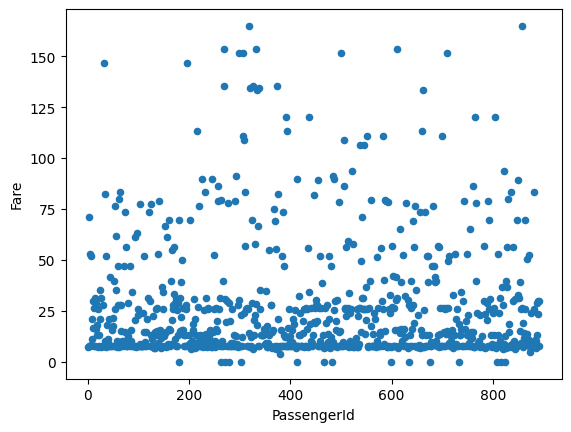

In [56]:
############################################
            # Outlieri varsta #
############################################

age_zscores = stats.zscore(df['Age'])

# cel mai asemanator cu iqr este pt 1.9
df_age_zscore = df[abs(age_zscores) <= 3]

############################################
            # Outlieri pret #
############################################

fare_zscores = stats.zscore(df_age_zscore['Fare'])

# cel mai asemanator cu iqr este pt 0.7
df_fare_zscore = df_age_zscore[abs(fare_zscores) <= 3]

#grafic cu valori eliminate
df_fare_zscore.plot(kind = 'scatter', x = 'PassengerId', y = 'Fare')
plt.show()

**Cerinta 4:** Dezvoltarea unui model de clasificare pentru prezicerea sanselor de supraviet, uire.

Protocolul de testare: Împărtiti setul de date în două componente: 80% pentru antrenare
si 20% pentru validare.

Preprocesarea datelor: încărcarea datelor (pandas), înlăturarea valorilor lipsă (ex: medie),
convertirea coloanele categorice (ex: Sex, Embarked) în valori numerice, normalizarea caracteristicilor numerice.

In [59]:
df_final = df_fare_zscore

# transforma Sex si Embarked in coloane numaerice
le = LabelEncoder()
le.fit(df_final['Sex'])
df_final.loc[:, 'Sex'] = le.transform(df_final['Sex'])

le = LabelEncoder()
le.fit(df_final['Embarked'])
df_final.loc[:, 'Embarked'] = le.transform(df_final['Embarked'])

# eliminarea din setul de date de intrare (train si test) a coloanelor 'Survived', 'Name', 'Ticket', 'Cabin'
X = df_final.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis='columns')

# normalizarea valorilor
for col in X:
  if col != 'PassengerId':
    max = np.max(df_final[col])
    X.loc[:, col] = X[col] / abs(max)

# setul de date de iesire (train si test) contine survived
y = df_final['Survived']

# imparte setul de date
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# antrenare cu decision tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.3988439306358382
